# Alert Inference for Torque-related Failure Identification



In [1]:
import datetime
import os
# from typing import List, Tuple, Set

import numpy as np
import pandas as pd
# import plotly.express as px
# import plotly.graph_objects as go
# from plotly.subplots import make_subplots
# from sklearn.preprocessing import MinMaxScaler, StandardScaler
# from scipy.signal import find_peaks
from tensorflow import keras
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm
import datetime
from datetime import timedelta

2022-11-23 04:09:12.019478: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib:/usr/local/cuda/lib64:/usr/local/cuda/extras/CUPTI/lib64:/opt/amazon/efa/lib64:/opt/amazon/openmpi/lib64:/usr/local/lib:/usr/lib:/lib:
2022-11-23 04:09:12.019497: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### 1. Function definitions
Define all the functions to extract an alert based on a particular concept, as well as other functions, such as data loading, etc.

In [2]:


#####################################################################
########These functions are for supporting get_std_spikes()##########

# define a Limit to rolling function to 6 hours wehn taking 120 samples. 
# def roll_limiting_std(a):
#     """
#     """
#     ix = a.index.max()
#     a = a.loc[ix-pd.Timedelta('6h'):ix]
#     return a.std()
# # define a Limit to rolling function to 6 hours wehn taking 120 samples. 
# def roll_limiting_mean(a):
#     """
#     """
#     ix = a.index.max()
#     a = a.loc[ix-pd.Timedelta('6h'):ix]
#     return a.mean()

# def roll_limiting_sum(a):
#     """
#     """
#     ix = a.index.max()
#     a = a.loc[ix-pd.Timedelta('6h'):ix]
#     return a.sum()

# def roll_limiting_diff_sum(a):
#     """
#     """
#     ix = a.index.max()
#     a = a.loc[ix-pd.Timedelta('6h'):ix]
#     return a.diff().sum()
#####################################################################
#####################################################################


# def get_std_spikes(well_data_df: pd.DataFrame,
#                    prediction_name: str,
#                    feature_name: str,
#                    config_dict: dict) -> pd.DataFrame:
#     """
#     get_ramping_alerts finds ramps for a given well.

#     :param well_data_df: dataframe containing all the data for a single well over which inference will be executed.
#     :param feature_name: the column name corresponding to features that is to be used in model inference.
#     :param prediction_name: the column name corresponding to prediction in which model inference will be recorded.
#     :param config_dict: a dictionary of model specific configuration (e.g. thresholds, etc.)
#     :return: ...
#     """
    
#     feature_df=well_data_df.loc[:,[feature_name]]
#     feature_df.loc[well_data_df[config_dict['operations_config']['operation_method']]==1,[feature_name]]=np.nan
#     feature_df.loc[well_data_df[config_dict['flush_config']['operation_method']]==1,[feature_name]]=np.nan
#     feature_df=feature_df[~feature_df[feature_name].isna()]
#     rolled_tag=feature_df[feature_name].rolling(120)
#     windowed_std=rolled_tag.apply(roll_limiting_std)
#     windowed_mean=rolled_tag.apply(roll_limiting_mean)
#     peaks=pd.DataFrame(index=windowed_std.index, columns=[feature_name])
#     for time_ind in windowed_std.index:
#         peaks.loc[time_ind,feature_name]=(windowed_std.loc[time_ind]-windowed_std.loc[windowed_std.loc[time_ind-pd.Timedelta("60min"):time_ind].index.min()])
#     peaks[feature_name]=peaks[feature_name]/windowed_mean#*np.sign(well_data_df[feat].rolling(120).apply(roll_limiting_diff_sum))
#     peaks[peaks<0]=0
#     peaks[rolled_tag.apply(roll_limiting_diff_sum)<0]=0 
#     well_data_df[prediction_name]=0
#     well_data_df.loc[peaks[peaks>config_dict['spike_diff_threshold']].dropna().index,[prediction_name]]=1

#     return well_data_df


def get_ramping_alerts(well_data_df: pd.DataFrame,
                       feature_name: str,
                       prediction_name: str,
                       config_dict: dict) -> pd.DataFrame:
    """
    get_ramping_alerts finds ramps for a given well.

    :param well_data_df: dataframe containing all the data for a single well over which inference will be executed.
    :param feature_name: the column name corresponding to features that is to be used in model inference.
    :param prediction_name: the column name corresponding to prediction in which model inference will be recorded.
    :param config_dict: a dictionary of model specific configuration (e.g. thresholds, etc.)
    :return: ...
    """
        
    time_increments=well_data_df.index.to_series().resample('12h').max()    
    torque_tag=well_data_df[feature_name]
    torque_tag=torque_tag.interpolate(method='linear', axis=0)
    differential=pd.DataFrame(index=time_increments,columns=['polynomial_diff'])
    well_data_df[prediction_name]=0
    for time in time_increments:
        if time - pd.Timedelta(config_dict['polynomial_days']) > time_increments[0]:
            x=torque_tag.loc[time-pd.Timedelta(config_dict['polynomial_days']):time]
            if not well_data_df[config_dict['flush_config']['operation_method']].loc[time-pd.Timedelta(config_dict['polynomial_days']):time].any():
                if not well_data_df[config_dict['operations_config']['operation_method']].loc[time-pd.Timedelta(config_dict['polynomial_days']):time].any():

#                     if len(x)>9360:
                    u_limit=x.mean()+(2.5*x.std())
                    l_limit=x.mean()-(2.5*x.std())
                    x[x > u_limit] = u_limit
                    x[x < l_limit] = l_limit
                    poly=np.polyfit(list(range(len(x))),x,deg=config_dict['polynomial_degree'])
                    differential['polynomial_diff'].loc[time]=pd.DataFrame(np.polyval(poly, list(range(len(x))))).diff().mean()[0]
    integral=differential['polynomial_diff'].rolling(config_dict['polynomial_days']).sum()

    for time in differential.index:
        if time - pd.Timedelta(config_dict['polynomial_days']) > well_data_df.index[0]:
            if integral.loc[time]>0:
                if integral.loc[time]*differential['polynomial_diff'].loc[time]*100000>config_dict['ramp_integral_threshold']:
                    well_data_df.loc[time-pd.Timedelta('12hr'):time,[prediction_name]]=1
    return well_data_df


def get_torque_spike_decay_alert(well_data_df: pd.DataFrame,
                                 feature_name: str,
                                 prediction_name: str,
                                 model_config: dict) -> pd.DataFrame:
    """
    get_spike_decay finds the torque spike decay regions for a given well.

    :param well_data_df: dataframe containing all the data for a single well over which inference will be executed.
    :param feature_name: the column name corresponding to feature that is to be used in model inference.
    :param prediction_name: the column name corresponding to prediction in which model inference will be recorded.
    :param model_config: a dictionary of model specific configuration (e.g. thresholds, etc.)
    :return: ...
    """

    model = keras.models.load_model(model_config['model_path'], compile=False)

    feature_data = well_data_df[feature_name].interpolate()
    feature_data_idx = well_data_df[feature_name].index.values
    window_size = model_config['window_size']
    window_overlap = model_config['window_overlap']
    binary_threshold = model_config['binary_threshold']

    num_windows = int(np.floor(feature_data.shape[0] / (window_size / 2)))
    window_starts = [int(i * window_size * (1 - window_overlap)) for i in range(num_windows)]
    window_ends = [int((i * window_size * (1 - window_overlap)) + window_size) for i in range(num_windows)]
    len_inference_timeframe = len(feature_data_idx)

    edge_effect_width = int(window_size / (2 ** 4))

    df = pd.DataFrame(index=feature_data_idx, columns=[prediction_name, f"{prediction_name}_tmp"])

    for window_start, window_end in tqdm(zip(window_starts, window_ends)):
        # get features (pad with zeros if not of length window_size)
#         print(f"window_start: {window_start} | window_end: {window_end}")
        fdata = np.expand_dims(feature_data[window_start:window_end], 0)
        if fdata.shape[1] < window_size:
            fdata = np.pad(fdata,
                           ((0, 0),
                            (0, window_size - fdata.shape[1])),
                           # 'constant', constant_values=(0, 0)
                           'edge'
                           )

        # get predictions of positive class (i.e. a present BDTA event)
        prediction = model.predict(fdata)[0, :, 1]

        # account for edge effects, except at start and end of inference timeframe
        # start of inference timeframe
        if window_start == 0:
            s_idx = window_start
            e_idx = window_end - 1 - edge_effect_width

            s_pred_idx = 0
            e_pred_idx = len(prediction) - edge_effect_width
            # end of inference timeframe
        elif (window_end > len_inference_timeframe):
            s_idx = window_start + edge_effect_width
            e_idx = len_inference_timeframe - 1

            s_pred_idx = edge_effect_width
            e_pred_idx = window_size - (window_end - len_inference_timeframe)

        # within inference timeframe
        else:
            s_idx = window_start + edge_effect_width
            e_idx = window_end - 1 - edge_effect_width

            s_pred_idx = edge_effect_width
            e_pred_idx = len(prediction) - edge_effect_width

        # get datetime indices
        dt_s_idx = df.index[s_idx]
        dt_e_idx = df.index[e_idx]

        # collate predictions in dataframe
        df.loc[dt_s_idx:dt_e_idx, f"{prediction_name}_tmp"] = prediction[s_pred_idx:e_pred_idx]
        df.loc[dt_s_idx:dt_e_idx, prediction_name] = df.loc[dt_s_idx:dt_e_idx].max(axis=1)

    well_data_df[prediction_name] = (df[prediction_name].values > binary_threshold) * 1
    
    # filter datetimes
    event_datetimes = get_event_datetimes(well_data_df[prediction_name],
                                          merge_event_overlap=model_config['merged_event_overlap']
                                         )
    
    if event_datetimes:
        print(f"Number of events detected: {len(event_datetimes)}")
        if (len(event_datetimes) > 0):
            mask = [((pd.to_datetime(event_datetime[1]) - pd.to_datetime(event_datetime[0])) > pd.Timedelta(minutes=model_config['miminum_event_length'])) for event_datetime in event_datetimes]
            filtered_event_datetimes = [x for x, y in zip(event_datetimes, mask) if y == True]

            well_data_df[f"{prediction_name}_filtered"] = 0
            for (start_datetime, end_datetime) in filtered_event_datetimes:
                well_data_df[f"{prediction_name}_filtered"].loc[start_datetime:end_datetime] = 1

            well_data_df[prediction_name] = well_data_df[f"{prediction_name}_filtered"]
            well_data_df = well_data_df.drop(columns=[f"{prediction_name}_filtered"])

    return well_data_df

# def get_torque_spike_decay_alert_single_window(well_data_df: pd.DataFrame,
#                                  feature_name: str,
#                                  prediction_name: str,
#                                  model_config: dict) -> pd.DataFrame:
#     """
#     get_spike_decay finds the torque spike decay regions for a given well.

#     :param well_data_df: dataframe containing all the data for a single well over which inference will be executed.
#     :param feature_name: the column name corresponding to feature that is to be used in model inference.
#     :param prediction_name: the column name corresponding to prediction in which model inference will be recorded.
#     :param model_config: a dictionary of model specific configuration (e.g. thresholds, etc.)
#     :return: ...
#     """

#     model = keras.models.load_model(model_config['model_path'], compile=False)

#     feature_data = well_data_df[feature_name].interpolate()
#     feature_data_idx = well_data_df[feature_name].index.values
#     window_size = model_config['window_size']
#     window_overlap = model_config['window_overlap']
#     binary_threshold = model_config['binary_threshold']

#     df = pd.DataFrame(index=feature_data_idx, columns=[prediction_name, f"{prediction_name}_tmp"])
    
#     fdata = np.expand_dims(feature_data, 0)
#     if fdata.shape[1] < window_size:
#         fdata = np.pad(fdata,
#                        ((0, 0),
#                         (0, window_size - fdata.shape[1])),
#                        # 'constant', constant_values=(0, 0)
#                        'edge'
#                        )
            
#     # get predictions of positive class (i.e. a present BDTA event)
#     prediction = model.predict(fdata)[0, :, 1]
#     df[prediction_name] = prediction

#     well_data_df[prediction_name] = (df[prediction_name].values > binary_threshold) * 1
    
#     # filter datetimes
#     event_datetimes = get_event_datetimes(well_data_df[prediction_name],
#                                           merge_event_overlap=model_config['merged_event_overlap']
#                                          )
    
#     if event_datetimes:
#         print(f"Number of events detected: {len(event_datetimes)}")
#         if (len(event_datetimes) > 0):
#             mask = [((pd.to_datetime(event_datetime[1]) - pd.to_datetime(event_datetime[0])) > pd.Timedelta(minutes=model_config['miminum_event_length'])) for event_datetime in event_datetimes]
#             filtered_event_datetimes = [x for x, y in zip(event_datetimes, mask) if y == True]

#             well_data_df[f"{prediction_name}_filtered"] = 0
#             for (start_datetime, end_datetime) in filtered_event_datetimes:
#                 well_data_df[f"{prediction_name}_filtered"].loc[start_datetime:end_datetime] = 1

#             well_data_df[prediction_name] = well_data_df[f"{prediction_name}_filtered"]
#             well_data_df = well_data_df.drop(columns=[f"{prediction_name}_filtered"])

#     return well_data_df

In [3]:
def load_data_from_disk(data_definition_dict: dict) -> pd.DataFrame:
    """
    Load raw data from CSV file
    
    
    """
    well_data_df = pd.read_csv(data_definition_dict['well_raw_data_path'])
    
    if 'Unnamed: 0' in well_data_df.columns:
        well_data_df.drop(columns=['Unnamed: 0'],inplace=True)

    well_data_df['TS'] = pd.to_datetime(well_data_df['TS'], format="%Y-%m-%d %H:%M:%S")
    well_data_df.set_index(['TS'], inplace=True, drop=True)
    
    well_data_df = well_data_df.loc[(well_data_df.index > data_definition_dict['start_date']) & (well_data_df.index < data_definition_dict['end_date'])]

#     print(f"Well data loaded for {data_definition_dict['well_id']} for date range {data_definition_dict['start_date']} - {data_definition_dict['end_date']}")

    return well_data_df


def which_feature(well_data_df, feature_cols):
    """
    Decide which feature to use.
    """

    vals=[]
    for t in feature_cols:
#         print(t,well_data_df[t].count())
        vals.append(well_data_df[t].count())
    return feature_cols[np.argmax(vals)]


def interpolate(well_data_df: pd.DataFrame) -> pd.DataFrame:
    return well_data_df.interpolate(method='linear', axis=0)


def resample_to_1min(well_data_df: pd.DataFrame) -> pd.DataFrame:
    return well_data_df.asfreq('T', method='nearest').resample('1min').mean()
#     well_data_df=well_data_df.reset_index()
#     well_data_df['TS']=well_data_df['TS'].dt.round('min')
#     return well_data_df.groupby(['TS']).mean()

def load_labels_from_disk(label_definition_dict: dict) -> pd.DataFrame:
    """
    Load labels from CSV file
    
    
    """
    label_df = pd.read_csv(label_definition_dict['label_data_path'])
    
    label_df = label_df[label_df['WellCD'] == label_definition_dict['well_id']]

    label_df['Event Date'] = pd.to_datetime(label_df['Event Date'], format="%d/%m/%Y")

    label_df.dropna(subset=['Event Date'], inplace=True)
    
    label_df = label_df[(label_df['Event Date'] > label_definition_dict['start_date']) & (label_df['Event Date'] < label_definition_dict['end_date'])]
    
    label_df.set_index('Event Date', inplace=True)

    print(f"Label data loaded for {label_definition_dict['well_id']} for date range {label_definition_dict['start_date']} - {label_definition_dict['end_date']}")

    return label_df

In [4]:
def get_operation_status(well_data_df: pd.DataFrame,
                         feature_name: str,
                         config_dict: dict):
    """
    get_off_times gets...

    :param well_data_df: dataframe containing all the data for a single well over which inference will be executed.
    :param config_dict: a dictionary of model specific configuration (e.g. thresholds, etc.)
    :return: ...
    """

    off_trace = pd.DataFrame(index=well_data_df.index, columns=[config_dict['operation_method']])
    off_trace[config_dict['operation_method']] = 0
    torque_well_data_df = well_data_df[feature_name].interpolate(method='linear', axis=0)
    off_times = torque_well_data_df[torque_well_data_df < config_dict['off_threshold']].index
    prev_point = well_data_df.index[0] - pd.Timedelta('6H')
    for point in off_times:
        if point > (prev_point + pd.Timedelta('5H')):
            off_trace[config_dict['operation_method']].loc[point - pd.Timedelta('62min'):point + pd.Timedelta('5H')] = 1
            prev_point = point
    well_data_df[config_dict['operation_method']] = off_trace

    return well_data_df


def get_flush_status(well_data_df: pd.DataFrame,
                     feature_name: str,
                     config_dict: dict) -> pd.DataFrame:
    """
    get_flush_status gets...

    :param well_data_df: dataframe containing all the data for a single well over which inference will be executed.
    :param config_dict: a dictionary of model specific configuration (e.g. thresholds, etc.)
    :return: ...
    """

    flush_trace = pd.DataFrame(index=well_data_df.index, columns=[config_dict['operation_method']])
    flush_trace[config_dict['operation_method']] = 0
    speed_well_data_df = well_data_df[feature_name].interpolate(method='linear', axis=0)
    flush_diff = speed_well_data_df[speed_well_data_df.diff(1).abs().rolling('2H').sum() > config_dict['flush_diff_threshold']]
    flush_std = speed_well_data_df[speed_well_data_df.rolling('2H').std() > config_dict['flush_std_threshold']]
    exlude_ind = flush_diff.index.intersection(flush_std.index)
    prev_point = well_data_df.index[0] - pd.Timedelta('6H')
    for point in exlude_ind:
        if point > (prev_point + pd.Timedelta('5H')):
            flush_trace[config_dict['operation_method']].loc[point - pd.Timedelta('180min'):point + pd.Timedelta('12H')] = 1
            prev_point = point
    well_data_df[config_dict['operation_method']] = flush_trace

    return well_data_df

In [5]:
def get_combined_alert(well_data_df: pd.DataFrame, alert_names: list, method: str = 'all') -> pd.DataFrame:
    """
    """

    if method == 'all':
        well_data_df['combined_alert'] = (well_data_df[alert_names] == 1).all(1).astype(int)
    elif method == 'any':
        well_data_df['combined_alert'] = (well_data_df[alert_names] == 1).any(1).astype(int)
    else:
        well_data_df['combined_alert'] = 0

    return well_data_df


def get_static_plot_for_single_alert(well_id: str,
                                     well_data_df: pd.DataFrame,
                                     features_to_plot: list,
                                     alert_names: str,
                                     label_data_df: pd.DataFrame = None,
                                     plot_type: str = 'scatter',
                                     ylim: list = [0, 1000],
                                     save_fig_fname: str = None
                                    ):
    """
    
    """
    
    fig = plt.figure(figsize=(50,8))
    
    for feature in features_to_plot:
        if feature in well_data_df.columns:
            if plot_type == 'scatter':
                plt.scatter(well_data_df.index, well_data_df[feature])
            if plot_type == 'line':
                tmp_plot_df = well_data_df.dropna(subset=[feature])
                plt.plot(tmp_plot_df.index, tmp_plot_df[feature])
    for alert in alert_names:
        plt.fill_between(x=well_data_df.index,
                         y1=ylim[0], #0,
                         y2=ylim[1], #int(well_data_df[features_to_plot[0]].dropna().max()*1.1),
                         where=well_data_df[alert],
#                          color='orange',
                         alpha=0.5,
                        )

    if not label_data_df.empty:
        for j, (idx, row) in enumerate(label_data_df.iterrows()):
            plt.vlines(x=idx,
                       ymin=ylim[0], #0,
                       ymax=ylim[1], #int(well_data_df[features_to_plot[0]].dropna().max()*1.1),
                       color='r'
                      )
            plt.text(x=idx,
                     y=int(ylim[1] * (0.6 + (0.01 * j))), #int(well_data_df[features_to_plot[0]].dropna().max()),
                     s=f"{row['Event']} - {row['Failure Mode']} - {row['Flush_Comment']}",
#                      rotation=90,
#                      verticalalignment='center'
                    )

    plt.rcParams.update({'font.size': 22})

    plt.legend(features_to_plot + alert_names)#[f"ALERT: {alert_names}"])
    plt.title(f"{well_id}")
    
    plt.ylim(ylim)
#     plt.show()
    
    if save_fig_fname:
        plt.savefig(save_fig_fname,
#                     *, dpi='figure', format=None, metadata=None,
#                     bbox_inches=None, pad_inches=0.1,
#                     facecolor='auto', edgecolor='auto',
#                     backend=None, **kwargs
                   )
        print(f"Figure saved to: {save_fig_fname}")

    return fig


def get_event_datetimes(event_data: pd.Series, merge_event_overlap: int = None):
    """
    param data:
    param merge_event_overlap:
    return event_datetimes:
    """
    inference_window_start_datetime = event_data.index[0]
    inference_window_end_datetime = event_data.index[-1]

    event_starts = event_data[event_data.diff() == 1].index.tolist()  # transition into an event
    event_ends = event_data[event_data.diff() == -1].index.tolist()  # transition out of an event

    if (len(event_starts) == 0) | (len(event_ends) == 0):
        return None

    # starts within event
    if len(event_starts) < len(event_ends):
        event_starts.insert(0, inference_window_start_datetime)

    # ends within event
    if len(event_starts) > len(event_ends):
        event_ends.append(inference_window_end_datetime)

    # starts and ends within event
    if len(event_starts) == len(event_ends):
        if event_starts[0] > event_ends[0]:
            event_starts.insert(0, inference_window_start_datetime)
            event_ends.append(inference_window_end_datetime)

    event_datetimes = [(s, e) for s, e in zip(event_starts, event_ends)]

    # merge events that are less than merge_event_overlap hours apart
    # TODO: Recursively merge events
#     if merge_event_overlap:
#         event_datetimes_merged = []
#         if len(event_datetimes) > 1:
#             t_old = event_datetimes[0]
#             for t in event_datetimes[1:]:
#                 if (t_old[1] + datetime.timedelta(hours=merge_event_overlap)) >= t[0]:
#                     t_old = ((min(t_old[0], t[0]), max(t_old[1], t[1])))
#                 else:
#                     event_datetimes_merged.append(t_old)
#                     t_old = t

#         event_datetimes = event_datetimes_merged

    return event_datetimes if len(event_datetimes) > 0 else None

# Generate the priority / Alert table for a given date


In [41]:
def alert_monitor_generation_all_wells(date: str,
                                       time_window: str,
                                       well_list: list,
                                      plot: bool,
                                     torque_names: list,
                                      completion_turndown_df: pd.DataFrame,
                                      label_data_df: pd.DataFrame) -> pd.DataFrame:
    start_date=pd.to_datetime(date)-pd.Timedelta('60d')
    end_date=pd.to_datetime(date)#+pd.Timedelta('26d')
    day_index=pd.date_range(start_date,end_date, freq='1h')
    all_well_spike_alert_df=pd.DataFrame(columns=well_list,index=day_index)
    all_well_ramp_alert_df=pd.DataFrame(columns=well_list,index=day_index)
    all_well_total_alert_df=pd.DataFrame(columns=well_list,index=day_index)
    todays_results_df=pd.DataFrame(index=well_list,columns=[
                                                            f'Spiking Present (past {time_window}ay/s)',
                                                            f'Ramping Present (past {time_window}ay/s)',
                                                            'Spiking Present (past month)',
                                                            'Ramping Present (past month)',
                                             
                                                                f'Spike Alert Percent Active Time in Past {time_window}ay/s',
                                                                'Spike Alert Percent Active Time in Past Week',
                                                                'Spike Alert Percent Active Time in Past 30 Days',
                                                                'Spike Alert Percent Active Time in Past 60 Days',
                                                                f'Ramp Alert Percent Active Time in Past {time_window}ay/s',
                                                                'Ramp Alert Percent Active Time in Past Week',
                                                                'Ramp Alert Percent Active Time in Past 30 Days',
                                                                'Ramp Alert Percent Active Time in Past 60 Days',
                                                               'Average gas flow (60 Days)',
                                                               'TD status',
                                                               'Design',
                                                               'Pump age',
                                                               'Days since last flush',
                                                                'Days since last failure',
                                                                f'Total Alert on minutes in Past {time_window}ay/s',
                                                               'Total Alert on minutes in Past Week',
                                                               'Total Alert on minutes in Past 30 Days',
                                                               'Total Alert on minutes in Past 60 Days',
                                                                f'Spike Alert on minutes in Past {time_window}ay/s',
                                                                'Spike Alert on minutes in Past Week',
                                                                'Spike Alert on minutes in Past 30 Days',
                                                                'Spike Alert on minutes in Past 60 Days',
                                                                f'Ramp Alert on minutes in Past {time_window}ay/s',
                                                                'Ramp Alert on minutes in Past Week',
                                                                'Ramp Alert on minutes in Past 30 Days',
                                                                'Ramp Alert on minutes in Past 60 Days',])
    

    speed_names = ['SPEED_MOTOR', 'SPEED_ROD']
                    
    for well_id in well_list:
        #peak_label_df is to be replaced by performing inference for the well here
#         peak_label_df=pd.read_pickle(f'/home/ec2-user/SageMaker/efs/labels/segnet_inference/BRETT_Multi_Well_Model_v2/{well_id}.pkl')

        data_definition_dict = {
            'well_id': well_id,
            'well_raw_data_path': Path(f"/home/ec2-user/SageMaker/efs/data/october_data_extract/tag_{well_id}.csv"),
            'start_date': pd.to_datetime(start_date, format="%Y-%m-%d"),
            'end_date': pd.to_datetime(end_date, format="%Y-%m-%d")
        }
        well_data_df = load_data_from_disk(data_definition_dict)
        if len(well_data_df)==0:
            print(f'EMPTY DATA FOR WELL {well_id}')
            pass
        else:
            # resample data
            well_data_df = resample_to_1min(well_data_df)

            torque_col = which_feature(well_data_df, torque_names)
#             print(f"Torque feature to be used: {torque_col}")

            speed_col = which_feature(well_data_df, speed_names)
#             print(f"Speed feature to be used: {speed_col}")
            ### PREPROCESSING
#             preprocessing_methods = [
#             #     'high_pass_filtering'
#             ]

            ###---------------------------------------
            ### PREPROCESSING - HIGH PASS FILTERING
            ###---------------------------------------

#             model_config = {
#                 'preprocessing_method': 'high_pass_filtered_data',
#                 'off_threshold': 10
#             }


#             if model_config['preprocessing_method'] in preprocessing_methods:
#                 print(f"Generating {model_config['preprocessing_method']}")
#                 well_data_df = get_high_pass_filtered_data(well_data_df,
#                                                            feature_name=torque_col,
#                                                            config_dict=model_config)

#                 print("Complete")

#             else:
#                 print(f"Did not generate {model_config['preprocessing_method']}")

#             ### OPERATION STATUS
            operation_methods = [
                'operation_status',
                'flush_status',
            ]

            ###---------------------------------------
            ### WELL OPERATION STATUS DETECTION - ON / OFF IDENTIFICATION
            ###---------------------------------------

            operations_config = {
                'operation_method': 'operation_status',
                'off_threshold': 10
            }


            if operations_config['operation_method'] in operation_methods:
#                 print(f"Generating {operations_config['operation_method']}")
                well_data_df = get_operation_status(well_data_df,
                                                    feature_name=torque_col,
                                                    config_dict=operations_config)


            ###---------------------------------------
            ### WELL FLUSH STATUS DETECTION
            ###---------------------------------------

            flush_config = {
                'operation_method': 'flush_status',
                'flush_diff_threshold': 4.9,
                'flush_std_threshold': 4,
            }

            if flush_config['operation_method'] in operation_methods:
#                 print(f"Generating {flush_config['operation_method']}")
                well_data_df = get_flush_status(well_data_df,
                                                feature_name=speed_col,
                                                config_dict=flush_config)


            ### Run inference for selected techniques on the loaded well data

            # this list will be populated with each technique used for the alert creation
            inference_methods = [
                'torque_spike_decay_alert',
                'ramping_alert',
            ]





            ###---------------------------------------
            ### RAMPING ALERT
            ###---------------------------------------

            model_config = {
                'inference_method': 'ramping_alert',
                'polynomial_degree': 4,
                'polynomial_days': '7d',
                'ramp_integral_threshold': 0.7,
                'operations_config': operations_config,
                'flush_config': flush_config,
            }

            if model_config['inference_method'] in inference_methods:
#                 print(f"Generating {model_config['inference_method']}")
                well_data_df = get_ramping_alerts(well_data_df,
                                                  feature_name=torque_col,
                                                  prediction_name=model_config['inference_method'],
                                                  config_dict=model_config)
#                 print("Complete")



            ###---------------------------------------
            ### TORQUE SPIKE DECAY DETECTION
            ###---------------------------------------

            model_config = {
                'inference_method': 'torque_spike_decay_alert',
                'model_path': Path("/home/ec2-user/SageMaker/efs/models/BRETT_Multi_Well_Model_v2.h5"),
                'window_size': 2 ** 14,
                'window_overlap': 0.5,
                'binary_threshold': 0.5,
                'merged_event_overlap': 10,
                'miminum_event_length': 0,
            }

            well_data_df[f"{torque_col}_roll_avg"] = well_data_df[torque_col].interpolate().rolling(120).mean()

            if model_config['inference_method'] in inference_methods:
#                 print(f"Generating {model_config['inference_method']}")
                well_data_df = get_torque_spike_decay_alert(well_data_df,
                                                            feature_name=f"{torque_col}",
                                                            prediction_name=model_config['inference_method'],
                                                            model_config=model_config)

            well_data_df['operation_status'] = (well_data_df['operation_status'] == 0) * 1
            well_data_df['flush_status'] = (well_data_df['flush_status'] == 0) * 1
            well_data_df = get_combined_alert(well_data_df, alert_names=['torque_spike_decay_alert', 'flush_status','operation_status'])
            peak_label_df=well_data_df.loc[:,['combined_alert']].resample('1h').sum()
            ramp_label_df=well_data_df.loc[:,['ramping_alert']].resample('1h').sum()
            total_alert_df=pd.DataFrame(index=peak_label_df.index)
            total_alert_df['total_alert']=well_data_df.loc[:,['combined_alert']].resample('1h').sum().values+well_data_df.loc[:,['ramping_alert']].resample('1h').sum().values
            all_well_spike_alert_df[well_id]=peak_label_df.reindex(index=all_well_spike_alert_df.index, method = 'nearest')
            all_well_ramp_alert_df[well_id]=ramp_label_df.reindex(index=all_well_ramp_alert_df.index, method = 'nearest')
            all_well_total_alert_df[well_id]=total_alert_df.reindex(index=all_well_spike_alert_df.index, method = 'nearest')

            if all_well_total_alert_df[well_id].loc[pd.to_datetime(date)-pd.Timedelta(time_window):pd.to_datetime(date)].sum()>0:
                if  peak_label_df.loc[pd.to_datetime(date)-pd.Timedelta(time_window):pd.to_datetime(date)].sum().values[0]>0:
                    todays_results_df.loc[well_id,[f'Spiking Present (past {time_window}ay/s)']]='True'
                else:
                    todays_results_df.loc[well_id,[f'Spiking Present (past {time_window}ay/s)']]='False'
                if  ramp_label_df.loc[pd.to_datetime(date)-pd.Timedelta(time_window):pd.to_datetime(date)].sum().values[0]>0:
                    todays_results_df.loc[well_id,[f'Ramping Present (past {time_window}ay/s)']]='True'
                else:
                    todays_results_df.loc[well_id,[f'Ramping Present (past {time_window}ay/s)']]='False' 
                    
                    
                if  peak_label_df.loc[pd.to_datetime(date)-pd.Timedelta('30d'):pd.to_datetime(date)].sum().values[0]>0:
                    todays_results_df.loc[well_id,['Spiking Present (past month)']]='True'
                else:
                    todays_results_df.loc[well_id,['Spiking Present (past month)']]='False'
                if  ramp_label_df.loc[pd.to_datetime(date)-pd.Timedelta('30d'):pd.to_datetime(date)].sum().values[0]>0:
                    todays_results_df.loc[well_id,['Ramping Present (past month)']]='True'
                else:
                    todays_results_df.loc[well_id,['Ramping Present (past month)']]='False' 
                

                todays_results_df.loc[well_id,[f'Total Alert on minutes in Past {time_window}ay/s']] = total_alert_df.loc[pd.to_datetime(date)-pd.Timedelta(time_window):pd.to_datetime(date)].sum().values[0]#+ramp_label_df.loc[pd.to_datetime(date)-pd.Timedelta(time_window):pd.to_datetime(date)].sum().values[0]
                todays_results_df.loc[well_id,['Total Alert on minutes in Past Week']] = total_alert_df.loc[pd.to_datetime(date)-pd.Timedelta('7d'):pd.to_datetime(date)].sum().values[0]#+ramp_label_df.loc[pd.to_datetime(date)-pd.Timedelta('7d'):pd.to_datetime(date)].sum().values[0]
                todays_results_df.loc[well_id,['Total Alert on minutes in Past 30 Days']] = total_alert_df.loc[pd.to_datetime(date)-pd.Timedelta('30d'):pd.to_datetime(date)].sum().values[0]#+ramp_label_df.loc[pd.to_datetime(date)-pd.Timedelta('30d'):pd.to_datetime(date)].sum().values[0]
                todays_results_df.loc[well_id,['Total Alert on minutes in Past 60 Days']] = total_alert_df.loc[start_date:pd.to_datetime(date)].sum().values[0]#+ramp_label_df.loc[start_date:pd.to_datetime(date)].sum().values[0]

                todays_results_df.loc[well_id,[f'Spike Alert on minutes in Past {time_window}ay/s']] = peak_label_df.loc[pd.to_datetime(date)-pd.Timedelta(time_window):pd.to_datetime(date)].sum().values[0]
                todays_results_df.loc[well_id,['Spike Alert on minutes in Past Week']] = peak_label_df.loc[pd.to_datetime(date)-pd.Timedelta('7d'):pd.to_datetime(date)].sum().values[0]
                todays_results_df.loc[well_id,['Spike Alert on minutes in Past 30 Days']] = peak_label_df.loc[pd.to_datetime(date)-pd.Timedelta('30d'):pd.to_datetime(date)].sum().values[0]
                todays_results_df.loc[well_id,['Spike Alert on minutes in Past 60 Days']] = peak_label_df.loc[start_date:pd.to_datetime(date)].sum().values[0]

                todays_results_df.loc[well_id,[f'Ramp Alert on minutes in Past {time_window}ay/s']] = ramp_label_df.loc[pd.to_datetime(date)-pd.Timedelta(time_window):pd.to_datetime(date)].sum().values[0]
                todays_results_df.loc[well_id,['Ramp Alert on minutes in Past Week']] = ramp_label_df.loc[pd.to_datetime(date)-pd.Timedelta('7d'):pd.to_datetime(date)].sum().values[0]
                todays_results_df.loc[well_id,['Ramp Alert on minutes in Past 30 Days']] = ramp_label_df.loc[pd.to_datetime(date)-pd.Timedelta('30d'):pd.to_datetime(date)].sum().values[0]
                todays_results_df.loc[well_id,['Ramp Alert on minutes in Past 60 Days']] = ramp_label_df.loc[start_date:pd.to_datetime(date)].sum().values[0]

                todays_results_df.loc[well_id,['Average gas flow (60 Days)']] = well_data_df.loc[start_date:date,["FLOW_GAS"]].interpolate("ffill").mean().values[0]
                todays_results_df.loc[well_id,['TD status']] = completion_turndown_df[completion_turndown_df['WellCD']==well_id]['Turndown Cat.'].values[0]
                todays_results_df.loc[well_id,['Design']] = completion_turndown_df[completion_turndown_df['WellCD']==well_id]['Completion Design'].values[0]
                todays_results_df.loc[well_id,['Pump age']] = pd.to_datetime(date)-label_data_df[(label_data_df['WellCD']==well_id) & (label_data_df.index < date)&(label_data_df['Event']=='Pump Change')].index.max()
                todays_results_df.loc[well_id,['Days since last flush']] = pd.to_datetime(date)-label_data_df[(label_data_df['WellCD']==well_id) & (label_data_df.index < date)&((label_data_df['Event']=='Scheduled')|(label_data_df['Event']=='Reactive')|(label_data_df['Event']=='Flushby'))].index.max()
                todays_results_df.loc[well_id,['Days since last failure']] = pd.to_datetime(date)-label_data_df[(label_data_df['WellCD']==well_id) & (label_data_df.index < date) & (label_data_df['Failure Mode'].notnull())].index.max()       

                todays_results_df.loc[well_id,[f'Spike Alert Percent Active Time in Past {time_window}ay/s']]=(todays_results_df.loc[well_id,[f'Spike Alert on minutes in Past {time_window}ay/s']].values[0]/(pd.Timedelta(time_window).total_seconds() / 60))*100
                todays_results_df.loc[well_id,['Spike Alert Percent Active Time in Past Week']]=(todays_results_df.loc[well_id,['Spike Alert on minutes in Past Week']].values[0] / 10080)*100
                todays_results_df.loc[well_id,['Spike Alert Percent Active Time in Past 30 Days']]=(todays_results_df.loc[well_id,['Spike Alert on minutes in Past 30 Days']].values[0]/43200)*100
                todays_results_df.loc[well_id,['Spike Alert Percent Active Time in Past 60 Days']]=(todays_results_df.loc[well_id,['Spike Alert on minutes in Past 60 Days']].values[0]/86400)*100
                                      
                todays_results_df.loc[well_id,[f'Ramp Alert Percent Active Time in Past {time_window}ay/s']]=(todays_results_df.loc[well_id,[f'Ramp Alert on minutes in Past {time_window}ay/s']].values[0]/(pd.Timedelta(time_window).total_seconds() / 60))*100
                todays_results_df.loc[well_id,['Ramp Alert Percent Active Time in Past Week']]=(todays_results_df.loc[well_id,['Ramp Alert on minutes in Past Week']].values[0] / 10080)*100
                todays_results_df.loc[well_id,['Ramp Alert Percent Active Time in Past 30 Days']]=(todays_results_df.loc[well_id,['Ramp Alert on minutes in Past 30 Days']].values[0]/43200)*100
                todays_results_df.loc[well_id,['Ramp Alert Percent Active Time in Past 60 Days']]=(todays_results_df.loc[well_id,['Ramp Alert on minutes in Past 60 Days']].values[0]/86400)*100
                
                
                if plot:
                    _ = get_static_plot_for_single_alert(well_id,
                                                     well_data_df.loc[start_date:date],
                                                     features_to_plot=[torque_col,
                                                                       'SPEED_ROD',
                                                                       'FLOW_GAS'
                                                                      ],
                                                     alert_names=['combined_alert','ramping_alert'],
                                                     label_data_df=label_data_df[label_data_df['WellCD']==well_id].loc[(label_data_df[label_data_df['WellCD']==well_id].index > start_date) & (label_data_df[label_data_df['WellCD']==well_id].index < end_date)],
                #                                      plot_type='line',
                #                                      ylim=[200, 800],
                #                                          save_fig_fname=f"/home/ec2-user/SageMaker/efs/plots_bs/seg_inference/v2/{well_id}_{start_date}_{end_date}.png"
                                                    )

    todays_results_df=todays_results_df.loc[pd.DataFrame(all_well_total_alert_df.loc[pd.to_datetime(date)-pd.Timedelta(time_window):pd.to_datetime(date)].sum())[all_well_total_alert_df.loc[pd.to_datetime(date)-pd.Timedelta(time_window):pd.to_datetime(date)].sum()>0].index]
    return todays_results_df.sort_values(by=f'Total Alert on minutes in Past {time_window}ay/s',ascending=False)#, peak_label_df, ramp_label_df,total_alert_df

10it [00:03,  2.80it/s]
/tmp/ipykernel_43937/2785044943.py:204: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  well_data_df[f"{prediction_name}_filtered"].loc[start_datetime:end_datetime] = 1


Number of events detected: 175
SEG 17.083333333333332


10it [00:03,  2.81it/s]
/tmp/ipykernel_43937/2785044943.py:204: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  well_data_df[f"{prediction_name}_filtered"].loc[start_datetime:end_datetime] = 1


Number of events detected: 4
SEG 11.319444444444445


10it [00:03,  2.80it/s]
/tmp/ipykernel_43937/2785044943.py:204: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  well_data_df[f"{prediction_name}_filtered"].loc[start_datetime:end_datetime] = 1


Number of events detected: 50
SEG 46.25


10it [00:03,  2.78it/s]
/tmp/ipykernel_43937/2785044943.py:204: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  well_data_df[f"{prediction_name}_filtered"].loc[start_datetime:end_datetime] = 1


Number of events detected: 44
SEG 7.777777777777778


10it [00:03,  2.60it/s]
/tmp/ipykernel_43937/2785044943.py:204: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  well_data_df[f"{prediction_name}_filtered"].loc[start_datetime:end_datetime] = 1


Number of events detected: 4
SEG 1.0416666666666665


10it [00:03,  2.73it/s]
/tmp/ipykernel_43937/2785044943.py:204: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  well_data_df[f"{prediction_name}_filtered"].loc[start_datetime:end_datetime] = 1


Number of events detected: 44
SEG 77.5
CPU times: user 48.8 s, sys: 3.03 s, total: 51.8 s
Wall time: 47.1 s


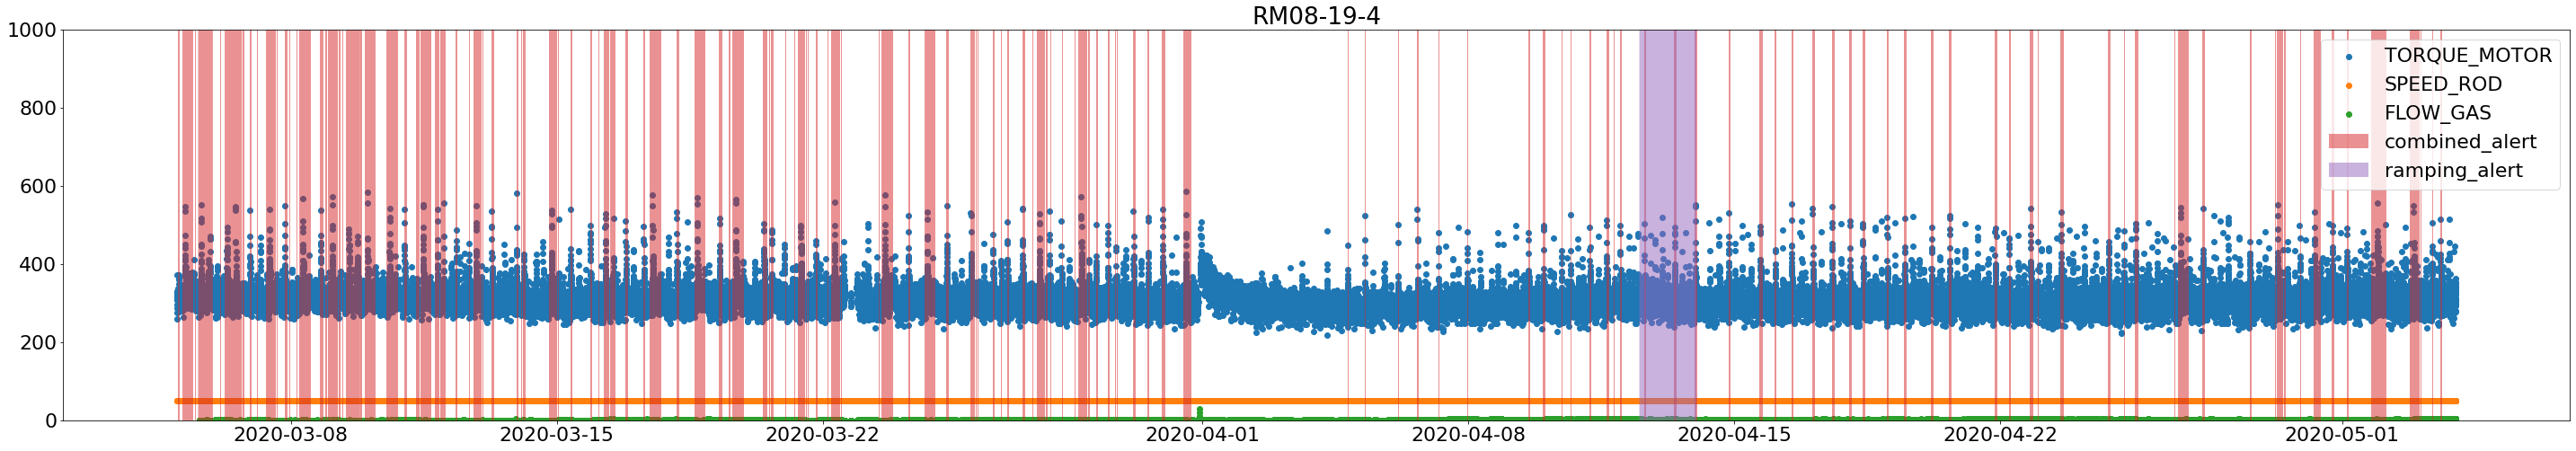

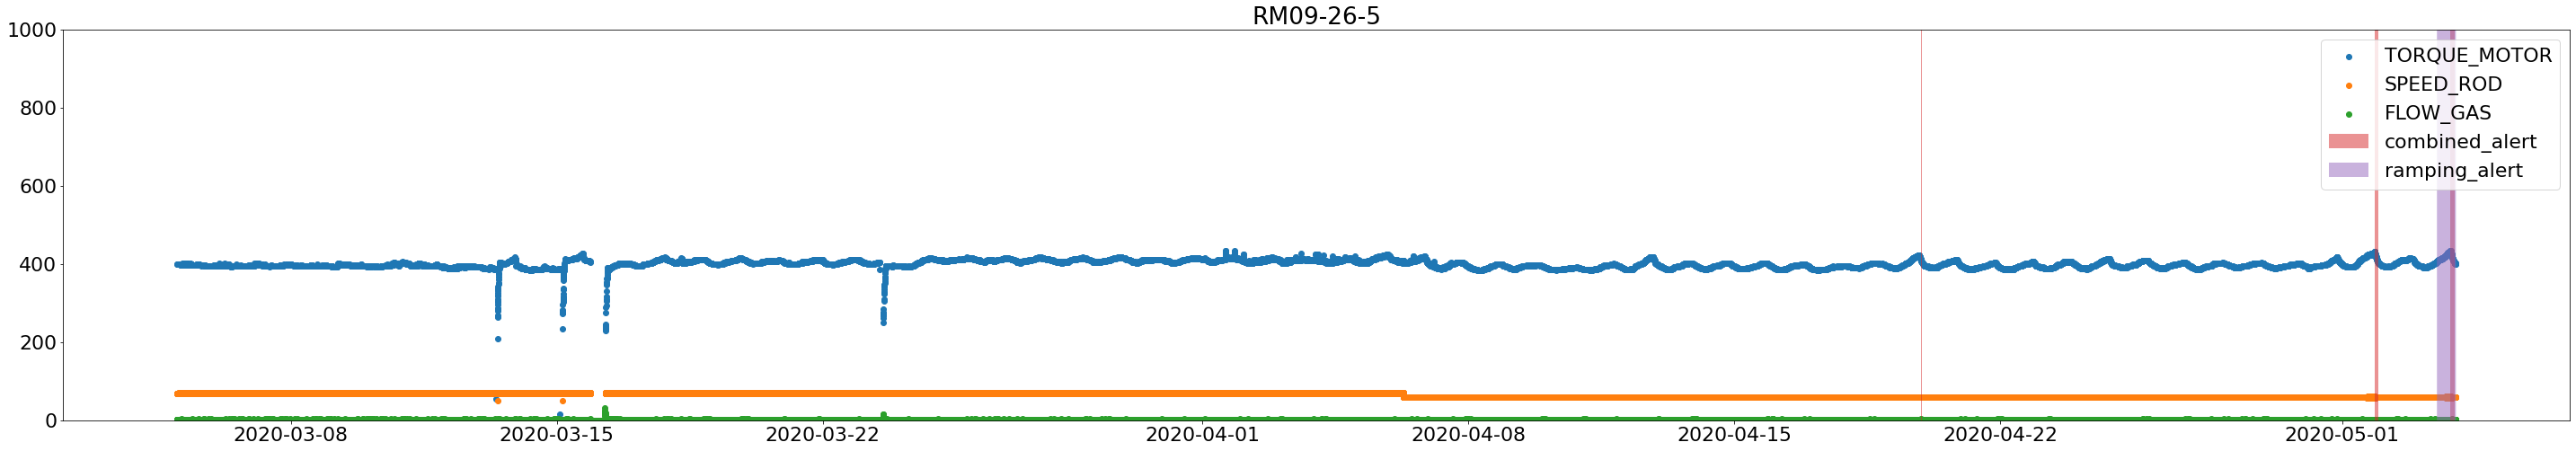

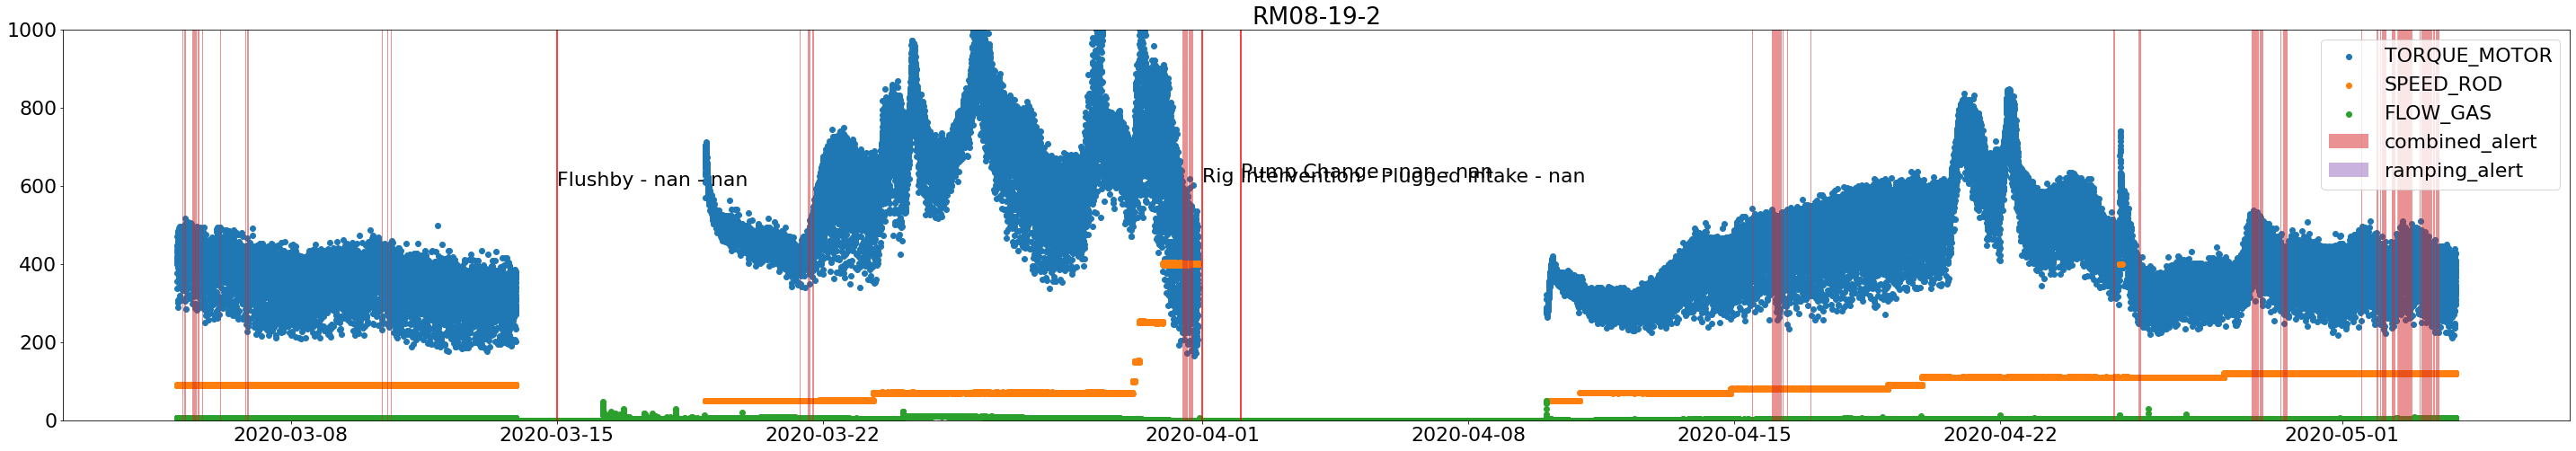

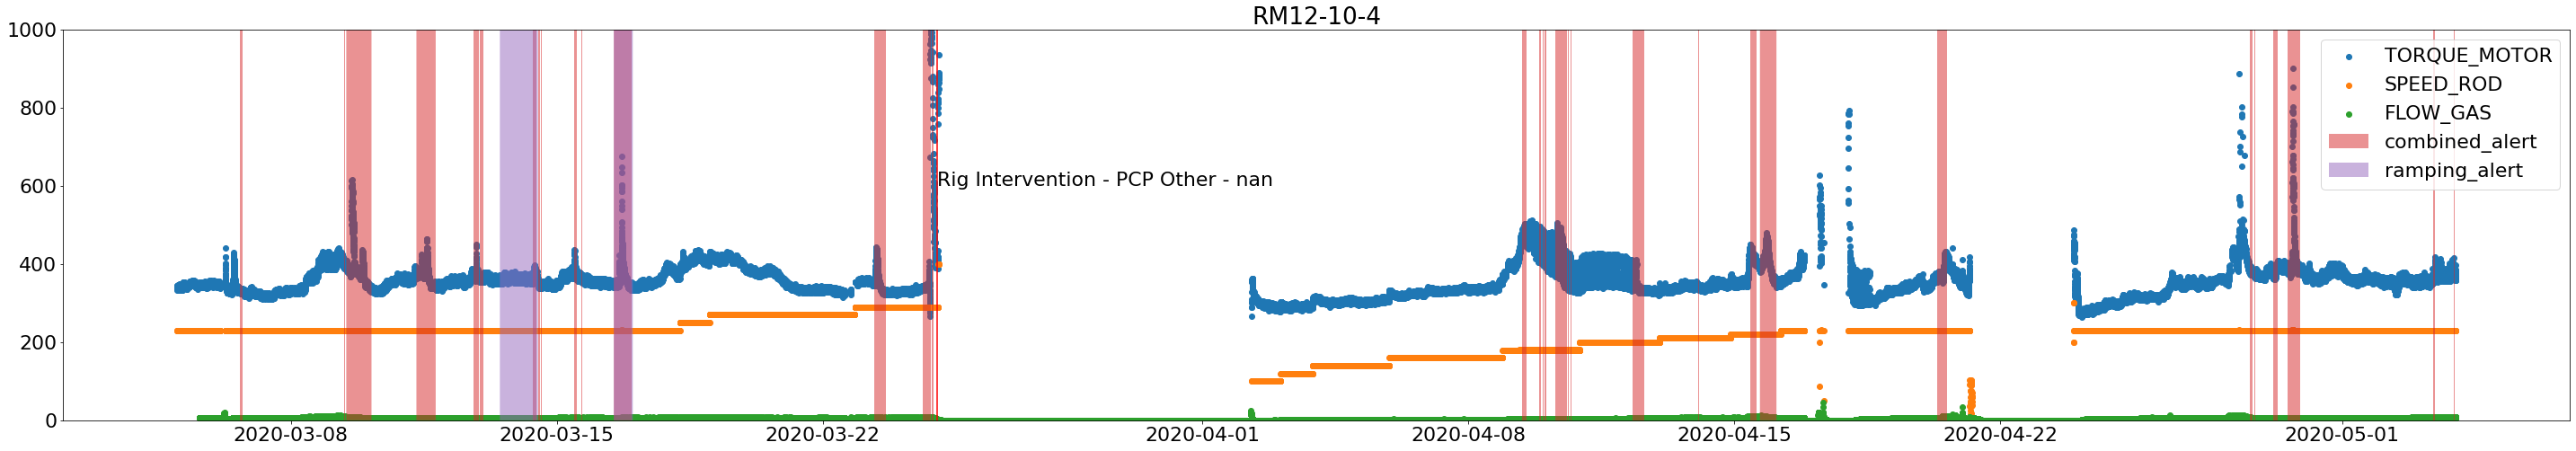

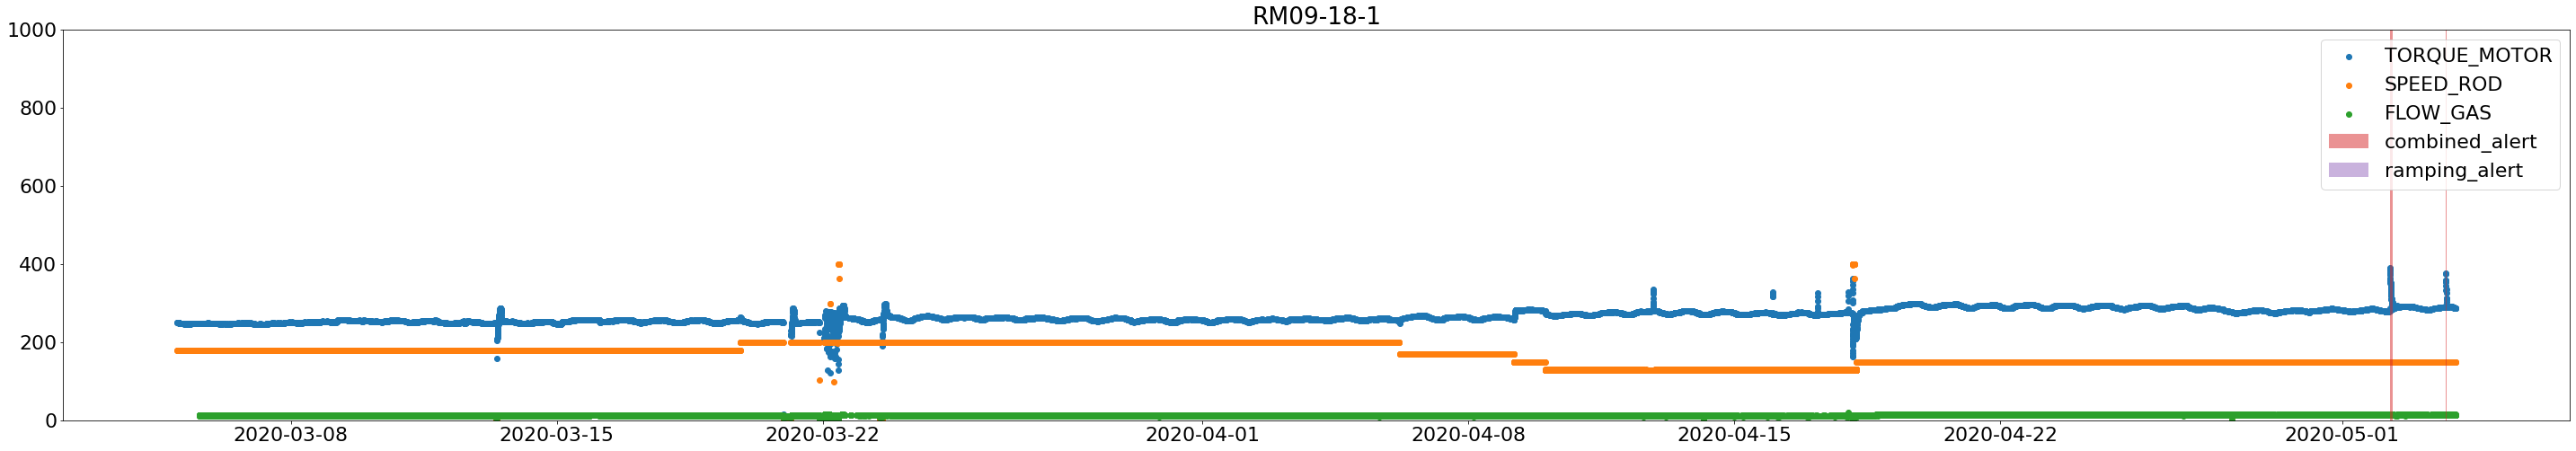

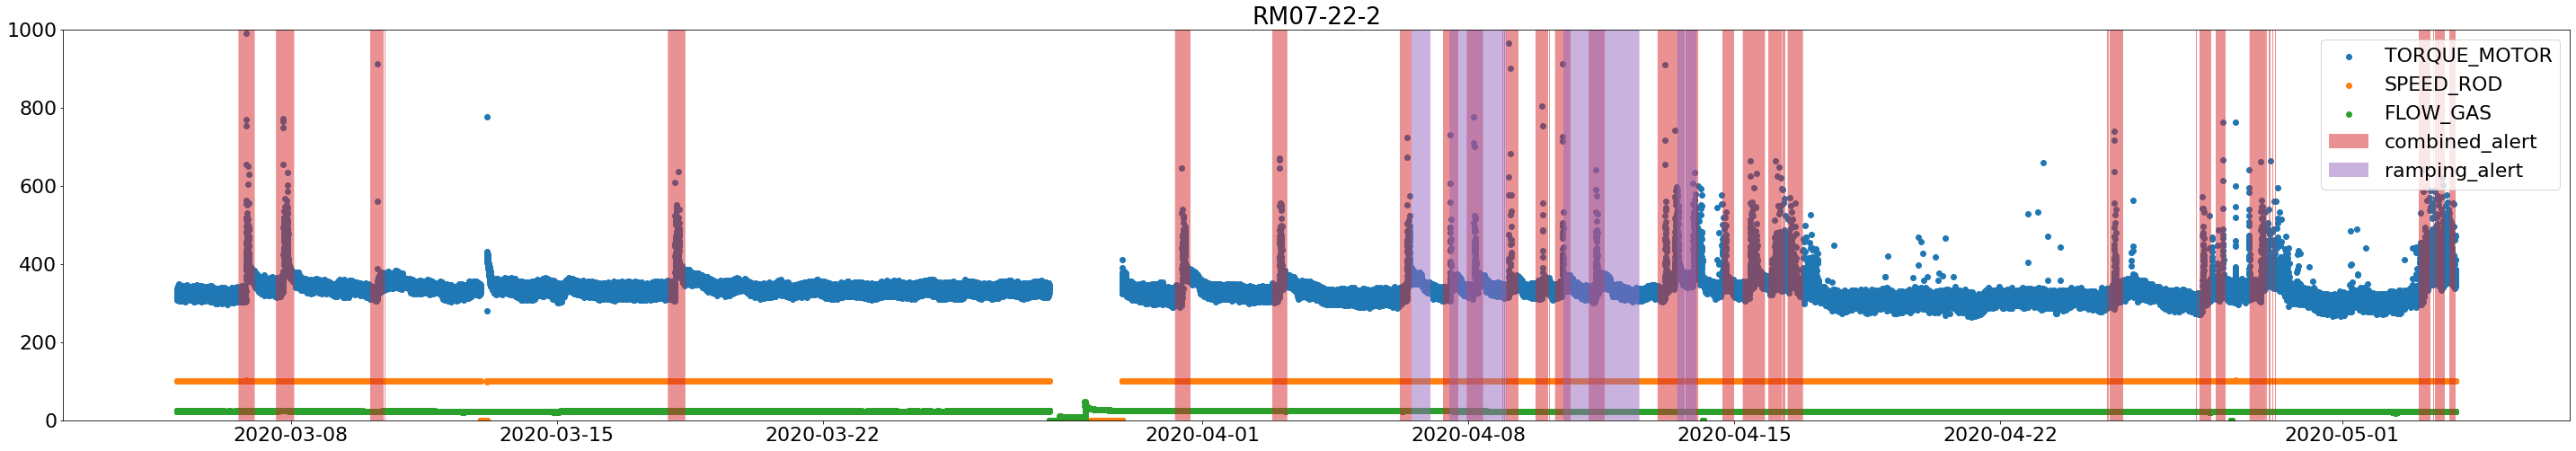

In [44]:
%%time
import glob
date=pd.to_datetime('2020-05-03 23:59:00')#  23:59:00
time_window='1d'
# file_list=glob.glob(f'/home/ec2-user/SageMaker/efs/labels/segnet_inference/BRETT_Multi_Well_Model_v2/*.pkl')
# well_list=[well.split('/')[-1].split('.')[0].split('_')[-1] for well in file_list]

well_list=[
    'RM08-19-4',
            'RM09-26-5',
            'RM08-19-2',
            'RM12-10-4',
            'RM09-18-1',
            'RM07-22-2'
]
torque_names = ['TORQUE_MOTOR', 'TORQUE_ROD']
completion_turndown_df=pd.read_csv(f'/home/ec2-user/SageMaker/efs/data/All_Roma_Completion_Turndown_ProductionStatus.csv')
label_data_df = pd.read_csv(f"/home/ec2-user/SageMaker/efs/data/All_Roma_Flush_Fail_PCPChange.csv")
label_data_df['Event Date'] = pd.to_datetime(label_data_df['Event Date'], format="%d/%m/%Y")
label_data_df.dropna(subset=['Event Date'], inplace=True)
label_data_df.set_index('Event Date', inplace=True)
# all_well_today_df, peak_label_df, ramp_label_df, total_alert_df=alert_monitor_generation_all_wells(date,
all_well_today_df=alert_monitor_generation_all_wells(date,
                                       time_window,
                                      well_list,
                                      1,
                                      torque_names, completion_turndown_df,label_data_df
)

In [45]:
all_well_today_df

,Spiking Present (past 1day/s),Ramping Present (past 1day/s),Spiking Present (past month),Ramping Present (past month),Spike Alert Percent Active Time in Past 1day/s,Spike Alert Percent Active Time in Past Week,Spike Alert Percent Active Time in Past 30 Days,Spike Alert Percent Active Time in Past 60 Days,Ramp Alert Percent Active Time in Past 1day/s,Ramp Alert Percent Active Time in Past Week,...,Total Alert on minutes in Past 30 Days,Total Alert on minutes in Past 60 Days,Spike Alert on minutes in Past 1day/s,Spike Alert on minutes in Past Week,Spike Alert on minutes in Past 30 Days,Spike Alert on minutes in Past 60 Days,Ramp Alert on minutes in Past 1day/s,Ramp Alert on minutes in Past Week,Ramp Alert on minutes in Past 30 Days,Ramp Alert on minutes in Past 60 Days
RM07-22-2,True,False,True,True,77.5,27.093254,25.997685,17.244213,0.0,0.0,...,17715,21383,1116,2731,11231,14899,0,0,6484,6484
RM09-26-5,True,True,True,True,11.319444,3.065476,0.784722,0.392361,50.069444,7.152778,...,1060,1060,163,309,339,339,721,721,721,721
RM08-19-2,True,False,True,False,46.25,22.390873,6.761574,4.844907,0.0,0.0,...,2921,4186,666,2257,2921,4186,0,0,0,0
RM08-19-4,True,False,True,True,17.083333,20.843254,12.481481,23.155093,0.0,0.0,...,7553,22167,246,2101,5392,20006,0,0,2161,2161
RM12-10-4,True,False,True,False,7.777778,9.335317,8.173611,8.791667,0.0,0.0,...,3531,9758,112,941,3531,7596,0,0,0,2162
RM09-18-1,True,False,True,False,1.041667,1.25,0.291667,0.145833,0.0,0.0,...,126,126,15,126,126,126,0,0,0,0


In [13]:
pd.Timedelta('1d').total_seconds() / 60

1440.0

In [46]:
all_well_today_df.to_csv('example_output_table.csv')